# Simulating Biological Networks

## In this section

- Discuss the types of biological networks
- Build a NetworkNode class to represent one node in a network
- Show how a collection of NetworkNode objects can collectively represent a network
- Simulate two models of network assembly (Erdos-Renyii and Barbasi-Alberts)

## Prerequisites

To complete this section, it's assumed you're already familiar with:
- basic python data structures (list,dict,string,int)
- functions in python
- classes in python (see the section on phylogenetics for an introduction)

## Table of Content

- Network Analysis in Bioinformatics

## Network Analysis in Bioinformatics

Network analysis is used for a wide variety of topics in bioinformatics. This includes analysis of gene regulatory networks (showing which genes activate or repress other genes), food webs, co-occurence networks of microorganisms, or metabolic networks. 

## Types of Networks

## Directed vs. Undirected Networks

## Weighted vs. Unweighted Networks

## Bi-, Tri- or Multipartite Networks

## Representing Networks in Python

### Building a NetworkNode object

In [1]:
from random import random
from copy import copy
from numpy.random import choice 
import matplotlib.pyplot as plt
from numpy import linspace
from random import randint

class NetworkNode(object):
    """A network node"""
    def __init__(self,edges=None,name=None,metadata={}):
        """initialize a NetworkNode object
        edges -- a list of NetworkNode objects symmetrically
          connected to self
        name -- the name of the node as a str
        metadata -- a dictionary of metadata about the node
        """
        self.Edges = []
        if edges:
            self.Edges = edges
            #assuming a symmetrical network,
            #so self is an edge of each neighbor
            for neighbor in self.Edges:
                neighbor.addEdge(self)         
        #Why not just self.Edges = edges?
        #default parameter values are created once
        #so that would sneakily make all nodes
        #share the same edge list!
        self.Name = name
        self.Metadata = copy(metadata)
        
        #Set a random x,y position for graphing
        #(doesn't affect network analysis)
        self.setRandomStartingPosition()
        
    def degree(self):
        """Returns the degree of the node"""
        result = len(self.Edges)  
        return result
    
    def addEdge(self,other):
        """Add an edge between self and another node"""
        if other not in self.Edges:
            self.Edges.append(other)
    
    def asString(self,field_delimiter="\t",list_delimiter=","):
        """Represent the node object as a string of name,edges,properties"""
        name = str(self.Name)
        edges = list_delimiter.join(map(str,[e.Name for e in self.Edges]))
        metadata = []
        for k,v in self.Metadata.items():
            metadata.append(":".join(map(str,[k,v]))) 
        metadata_str = list_delimiter.join(metadata)
        data_fields = field_delimiter.join([name,edges,metadata_str])+"\n"
        
        return data_fields
    
    def setRandomStartingPosition(self,min_x=0,max_x=500,min_y=0,max_y=500):
        """If node has no x or y Metadata, assign random starting positions"""
        random_x = randint(min_x,max_x)
        random_y = randint(min_y,max_y)
        self.Metadata["x"] = self.Metadata.get("x",random_x)
        self.Metadata["y"] = self.Metadata.get("y",random_y)
         
        

In [2]:
class Network(object):
    """A Network graph"""
    def __init__(self,nodes=None):
        """Generate network from nodes"""
        self.Nodes = []
        if nodes:
            self.Nodes = copy(nodes)

    def degree(self):
        """Return a dict of node name:node degree"""
        return {n.Name:n.degree() for n in self.Nodes}

    def addNode(self,node):
        """Add a NetworkNode object to the network"""
        self.Nodes.append(node)

    def asString(self):
        """Return a representation of the current Network as a string"""
        result = []
        for n in self.Nodes:
            result.append(n.asString())
        return "".join(result)

    def enumerateNodePairIndices(self,skip_self_pairs=True):
        n_Nodes = len(self.Nodes)
        for i in range(n_Nodes):
            for j in range(n_Nodes):
                if skip_self_pairs and i==j:
                    continue

                yield i,j

    def connectNodesRandom(self,p):
        """Randomly add edges between all node pairs with uniform probability p
        p -- the probability that two nodes will be connected  
        """
        for i,j in self.enumerateNodePairIndices():
            #Don't add edges between node
            #and itself
            if i == j:
                continue

            if random() <= p:
                self.Nodes[i].addEdge(self.Nodes[j])
                self.Nodes[j].addEdge(self.Nodes[i])

    def plot(self,outfile="network.png",\
        x_max=300.0,y_max=300.0,node_size=30.0):
        """Save a network plot
        x_attr -- metadata key to use for x locations
        y_attr -- metadata key to use for y locations
        """
        #Plot nodes as a scatterplot 
        x_coords = []
        y_coords = []
        for i,node in enumerate(self.Nodes):
            x = node.Metadata["x"]
            y = node.Metadata["y"]

            x_coords.append(x)
            y_coords.append(y)
        
        fig, ax = plt.subplots()
        
        
        # Remove axis lines.
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axis('off')
        
        #First plot edges connecting pairs of nodes
        for i,j in self.enumerateNodePairIndices():
            n1 = self.Nodes[i]
            n2 = self.Nodes[j]
            #Assume undirected
            if n1 in n2.Edges or n2 in n1.Edges:
                start_x = x_coords[i]
                start_y = y_coords[i]
                end_x = x_coords[j]
                end_y = y_coords[j]
                ax.plot([start_x,end_x],[start_y,end_y],'k-',alpha=0.25,zorder=1)
                
        #outline points in white by plotting larger white points behind them
        ax.scatter(x_coords, y_coords, color = 'white',s = node_size * 10, zorder=2)
        ax.scatter(x_coords, y_coords, color = 'purple',s = node_size, zorder=3)
        
        plt.savefig(outfile)

## Models of Network formation

If we have some mathematical models for network formation, we can simulate thousands of networks under that model, and then compare the properties of our *real* network to our various models. It may become clear that one model explains the data much better than the others. That is, the higher the *hypothetical* chances of getting a network that looks like the *real* network we observe, the better the model is.

Two very commonly used models of network formation are the Erdos-Renyi and Barabassi-Alberts models. We will explore these because they are very commonly referenced. However, for a real biological problem, you should consider the possible biological processes by which the network forms, and test models that will distinguish between those possibilities. 

### Simulating an Erdos-Renyi random network

Erdos-Renyi random networks assume that there are *n* nodes. Then for each pair of nodes, there is a chance, *p*, that they form a connction. Thus, pairs of nodes all have even or *uniform* chances of having 0,1,2, or more connections.

We can simulate an Erdos-Renyi random network, drawing on our NetworkNode object from up above.

In [3]:
def erdos_renyi_random_network(n,p):
    """Define a random Erdos-Renyi network with n nodes
    n - number of nodes
    p - probability any pair of nodes is connected
    """
    #Generate nodes
    network = Network()
    for i in range(n):
        curr_node = NetworkNode(name=i)
        network.addNode(curr_node)
    #Connect nodes
    #Note the function doesn't need to return anything
    #as the Node objects are modified 'in place' rather
    #than copied.
    network.connectNodesRandom(p)

    return network

Let's try it out and plot the results!

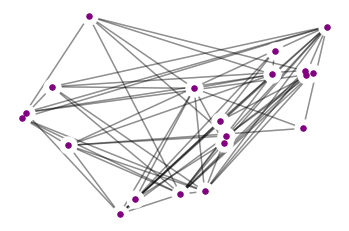

In [4]:
er_network = erdos_renyi_random_network(20,0.15)
er_network.plot()

## Simulating Barbasi-Alberts random networks

In studying real networks, it quickly became clear that while Erdos-Renyi networks are easy to explain, they don't match many networks in the real world. One reason is that in an Erdos-Renyi network, all the nodes are assumed to connect at the same time, with equal probability. 

But this isn't how real networks form. Instead, real networks grow over time. For example, you might meet one person, who in turn introduces you to three others. Or a protein that regulates one gene  may come to regulate multiple genes as the genome evolves. 

Networks that form by these types of processes show what are called 'small-world' properties. There are a few nodes with many connections, and many nodes with few connections.

Barbasi-Alberts random networks address this sort of pattern by assuming that not all nodes have equal opportunities to form connections. Instead, the **the chances of each node forming a connection are proportional to how many connections it already has**. In this type of network, 'winners win'. For example, people who already have some friends may be most likely to form new friendships.

So to simulate this type of network formation, we specify how many nodes we want in total in the network. 
We have to first start with two connected nodes, then add more connected nodes until we have the size of network we want. 

As we add nodes we will need to make sure they are most likely to attach to the existing nodes that *already* have the most connections. To do this we give each node a *weight* that measures how many nodes it is connected to (the **degree** of that node), divided by the total number of connections in the whole network. 

Finally, we randomly pick which node to add our new node to using the weights we calculated. After many repetitions of this process inside a loop, we'll form a whole network.

In [5]:
def barbasi_albert_random_network(desired_size):
    """Generate a Barbasi-Albert random network
    desired_size -- desired number of nodes (integer)
    """
    #Seed a minimal start network of two 
    #*connected* nodes
    network = Network()
    network.addNode(NetworkNode(name="1"))
    network.addNode(NetworkNode(name="2"))
    n0,n1 = network.Nodes
    n0.addEdge(n1)
    n1.addEdge(n0)

    current_size = len(network.Nodes)
    curr_node_name = 2
    #Repeatedly add nodes until network is the right size
    while len(network.Nodes) < desired_size:
        total_degree = sum([n.degree() for n in network.Nodes])
        node_weights = [float(n.degree())/total_degree for n in network.Nodes]
        #Pick a location to attach new node, using weighted random 
        #Note the result is an array with 1 element, so the [0]
        #accesses the chosen node
        attachment_node = choice(network.Nodes,1,p=node_weights)[0]
        new_node = NetworkNode(name=curr_node_name,edges = [attachment_node])
        network.addNode(new_node)
        attachment_node.addEdge(new_node)
        curr_node_name +=1
    return network

Let's try it out and plot the results!

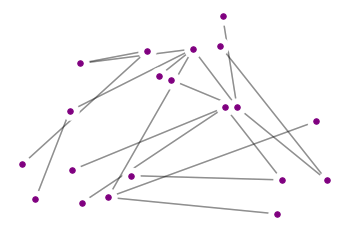

In [6]:
ba_network = barbasi_albert_random_network(20)
ba_network.plot()

## Degree distributions for Random Networks

One way to quantify the shape of a network is by measuring how many connections each node has. The number of connections a node has is called it's **degree**. For directed networks, researchers distinguish beween **in-degree** (the number of incoming connections) and **out-degree** (the number of outgoing connections). A **degree distribution** can be thought of as a histogram, showing how many nodes have what degree. In other words, a degree distribution answers the question of how common it is for a node to have 0,1,2 or more connections.

We've already seen visually that Barbassi-Alberts networks tend to have some nodes with lots of connections, and many nodes with very few connections. In contrast, nodes in Erdos-Renyi networks tend to be more similar in their number of connections.

Let's use our network and simulation code from up above to simulate ER or BA networks, calculate their degree distributions, and plot them as a histogram.

We'll start with a function to plot some histograms and save resulting images to a file. You can skim or skip this code if you like - it's pretty closely adapted from the [histogram tutorials](https://matplotlib.org/stable/gallery/statistics/histogram_multihist.html) in matplotlib. 

In [7]:
def plot_multiple_histogram(datasets,colors,labels,outfile,title = None):
    """Plot a multiple histogram of several datasets
    datasets -- list of data
    colors -- list of colors
    outfile -- file location to save histogram
    """
    fontsize = 16
    if len(colors) < len(datasets):
        raise ValueError("Need to specify one color per dataset")

    if len(labels) < len(datasets):
        raise ValueError("Need to specify one label per dataset")
    fig,ax = plt.subplots()
    all_data = []
    for d in datasets:
        all_data.extend(d)
    max_val = max(map(int,all_data))
    bins = linspace(0,max_val,15)
    plt.xlabel("Value",fontsize=fontsize)
    plt.ylabel("Frequency",fontsize=fontsize)
    common_params={'histtype':'stepfilled','alpha':0.50,'bins':bins,'edgecolor':'black'}
    print("Plotting histogram")
    for i,dataset in enumerate(datasets):
        ax.hist(dataset,facecolor=colors[i],label=labels[i],density = True,**common_params)

    # Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    if title:
        plt.title(title)
    plt.legend(fontsize=fontsize, frameon = False)
    plt.savefig(outfile)

Now let's combine simulating ER and BA networks, plotting the networks, calculating their degree distibutions, finally generating a degree distribution plot using our histogram plotting code.

We'll also write the networks to datafiles so we could study them later if we wanted to.

Generating Erdos-Renyi network 0.015000
Generating Barbasi-Albert network
Plotting histogram


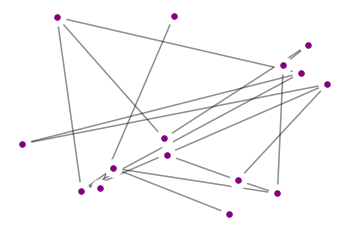

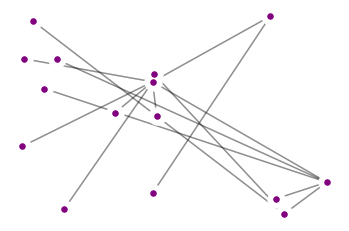

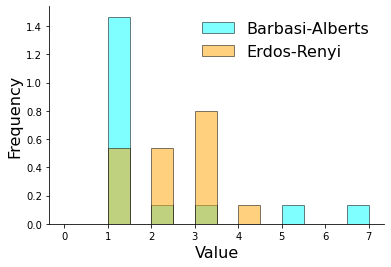

In [8]:
graph_outfile1 = "erdos_renyi_network.png"
data_outfile1 = "erdos_renyi_network.tab"
graph_outfile2 = "barbasi_alberts_network.png"
data_outfile2 = "barbasi_alberts_network.tab"
histogram_outfile = 'histogram.png'
n_nodes = 15
er_p = 0.10
er_network = erdos_renyi_random_network(n_nodes,er_p)

print("Generating Erdos-Renyi network %f" %(0.015))
network_datafile = open(data_outfile1,"w+")

er_node_degrees = sorted(er_network.degree().values())

data = er_network.asString()
network_datafile.write(data)
network_datafile.close()
er_network.plot(graph_outfile1)

print("Generating Barbasi-Albert network")
ba_network = barbasi_albert_random_network(n_nodes)

ba_node_degrees = sorted(ba_network.degree().values())

network_datafile = open(data_outfile2,"w+")
data = ba_network.asString()
network_datafile.write(data)
network_datafile.close()
ba_network.plot(graph_outfile2)

plot_multiple_histogram([ba_node_degrees,er_node_degrees],\
  colors = ['cyan','orange'],labels=["Barbasi-Alberts","Erdos-Renyi"],\
  outfile=histogram_outfile)


### Force Directed Graph Layout

Currently, we are just plotting the positions of each network node at random, then connecting them with arrows. We can do better using a **graph layout** algorithm. These algorithms are just formal ways of putting our network nodes onto a plot so they are arranged in a reasonable way. There are multiple different type of graph layout, that each have different advantages and disadvantages for data visualization.

Here we will focus on one type of popular graph layout called a force-directed graph layout. The 'force-directed' part of the name refers to forces in physics: we will imagine that all nodes are pushed away from each other (a repulsive force), while nodes connected by an edge are treated as if they are attached by springs. This makes connected nodes attract to one another if they get stretched too far apart. Together these attractive and repulsive forces cause our network nodes to spread out over the graph, while still staying close to the nodes they are connected to. 

The code we will be using is a python implementation of an algorithm described in [McGuffin et al., 2012](https://profs.etsmtl.ca/mmcguffin/research/2012-mcguffin-simpleNetVis/mcguffin-2012-simpleNetVis.pdf) 

#### Write and understand a function for calculating the spring force

If we are to use spring forces to keep network nodes that connect in similar parts of the graph, we should
probably understand how springs work. [Hooke's law](https://en.wikipedia.org/wiki/Hooke%27s_law) shows that there is a simple linear relationship between how much you've stretched or squished a spring from its resting position.

More formally, Hooke's law says that for a spring with position *x* and resting length *L*, the amount of force exerted by the spring depends on how far past the springs resting position (*L*) it's current length is (*x*) is, along with how strong of a spring we've got - as described by a final variable *k*, the spring constant.

In other words:

F<sub>s</sub> = *k* * (*L* -  *x*)

Where F<sub>s</sub> is the force exerted by the spring. When *x* is less than *L*, the spring is compressed and pushes by exerting a positive F<sub>s</sub>. If *x* is greater than *L*, the spring is stretched out, and exerts a negative F<sub>s</sub> to try to pull itself back into its resting position. The higher the spring constant *k* is, the more force the spring exerts  when compressed or stretched.

Okay - so before we do fancy stuff integrating Hooke's law into our networks to make the nodes bounce and jiggle around until they find nice positions, let's first make sure we can implement Hooke's law itself in a simple function.

In [9]:
def calc_directional_spring_force(x,k=2.5,L=100.0):
    """Calculate spring force along one axis (x)
    
    Parameters
    ----------
    dx : distance along the axis you want to calculate
    total_distance: the total distance across all dimensions between the two points
    K_s: the strength of the spring (higher tends to enforce distances close to spring length)
    L: the resting length of the spring
    """
    spring_force = k * (L - x)
    return spring_force

Let's test our function on an example: if x is 10.0 and L is 5.0, we expect a negative result, since we've stretched the spring. Let's try it out!

In [10]:
F_s = calc_directional_spring_force(x=10.0,L=5.0)
print("The force is: ",F_s)

The force is:  -12.5


Looks like things are working!

## Plotting spring force for a spring stretched various amounts

Let's examine how Hooke's law will exert force on our node using a plot. We'll write a function to plot a figure showing how spring force (y-axis) varies with distance (x-axis).



In [11]:
def get_spring_forces(L,k,min_x=0,max_x=500,step_size=25):
    """Return x,force lists for a spring with constant k and resting length at various x values
    
    :param L: the length of the Spring at rest
    :param k: the spring constant
    :param min_x: lowest x value to plot
    :param max_x: highest x value to plot
    :param step_size: how much to increase x each time we plot a point
    """
    #Create lists of x and y 
    #coordinates to hold our data
    #for the current spring
    xs = []
    ys = []

    #For each spring, test lots of starting positions
    for x in range(min_x,max_x,step_size):
        spring_length = 250.0
        spring_strength = 2.5
        y = calc_directional_spring_force(x,k,L=spring_length)
        xs.append(x)
        ys.append(y)
        
    return xs,ys

Now let's actually call our function to plot the spring forces

Text(0.5, 0, 'Distance (x)')

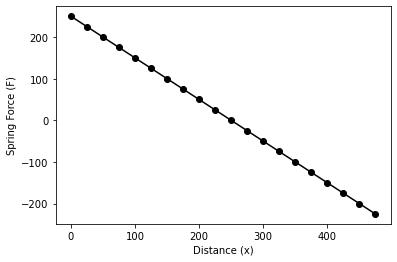

In [12]:
spring_length = 250.0
spring_constant = 1.0
color = "black"
xs,ys = get_spring_forces(k=spring_constant,L=spring_length)
#Plot the spring forces
plt.plot(xs,ys,c=color,marker="o")

#Label axes (optional)
plt.ylabel("Spring Force (F)")
plt.xlabel("Distance (x)")

### Making an improved plot of spring force vs. distance

**This next step can be skipped if you like** It just shows how we can workshop the figure above and make it easier to interpret. I include it because you might want to use some of the tricks to workshop your own figures.

As expected, we see a linear relationship between how much the spring is streched and how much force it's exerting.

We can make the figure easier to read by marking the resting spring length, using arrows to show stretching/compression, and using a vertical line to mark the 'resting length' of the spring.

<Figure size 432x288 with 0 Axes>

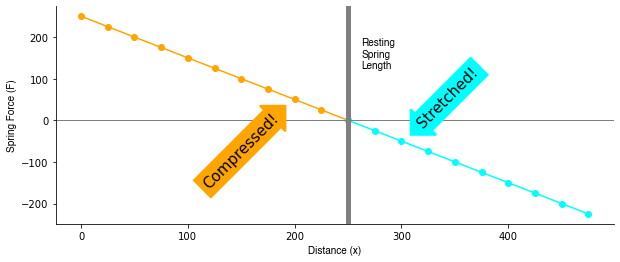

In [13]:

#Set some values for our spring
spring_length = 250.0
spring_constant = 1.0

#Set up a blank plot
plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

#Label axes
fontsize = 32
font = "Helvetica"
plt.ylabel("Spring Force (F)",fontsize= fontsize,font= font)
plt.xlabel("Distance (x)",fontsize= fontsize,font = font)

#get our x and y values
xs,ys = get_spring_forces(k=spring_constant,L=spring_length)

#Plot the spring forces before moving on to another
plt.plot([x for x in xs if x <= spring_length],[y for y in ys if y >= 0],color='orange',marker="o")
plt.plot([x for x in xs if x >= spring_length],[y for y in ys if y <= 0],color='cyan',marker="o")

#Add a vertical line and some text
#to mark the spring length
plt.axvline(x = spring_length,color="grey",linewidth = 5.0)

#Add horizontal line to mark division
#of + or negative force
plt.axhline(y = 0,color="grey",linewidth=1.0)

#Set up some parameters for a text label
#marking the spring's resting position

label_x_position = spring_length * 1.05
label_y_position = spring_length/2.0


#Add the text label (using \n to break it into 3 lines)
plt.annotate("Resting\nSpring\nLength", (label_x_position,label_y_position),\
 fontsize=fontsize,font = font)

#Use a fancy arow to mark where the spring is compressed
#(For a tutorial see here: https://matplotlib.org/stable/tutorials/text/annotations.html)

plt.text(spring_length *0.75, 0.10 * spring_length, "Compressed!", \
  ha="right", va="top", rotation=45, size=15,
  bbox=dict(boxstyle="rarrow",pad=0.3, fc="orange", ec="orange", lw=2))

#Use another fancy arrow to mark where the spring is stretched
plt.text(spring_length *1.25, -0.1 *spring_length, "Stretched!", \
  ha="left", va="bottom", rotation=45, size=15,
  bbox=dict(boxstyle="larrow",pad=0.3, fc="cyan", ec="cyan", lw=2))

#Note: I had to fuss with the x and y locations for these labels a ton. This is one of
#those things that generally has to be done by hand :(

# Remove extra axis lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

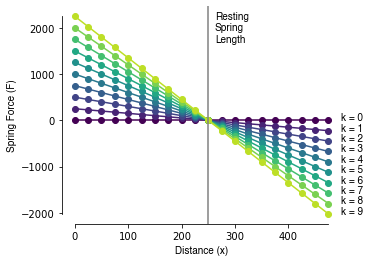

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

#Cycle through lots of spring constants k
#For each one, plot what happens to the spring
min_k = 0
max_k = 10
spring_length = 250.0

#We have to be careful to keept these as ints if we want to
#use range
for k in range(int(min_k),int(max_k)):
    #We'll use colored lines to plot 
    #each spring. The plt.cm module
    #has many 'colormaps' that
    #translate numbers from 0-1 to
    #colors
    color = plt.cm.viridis(k/max_k) 
    
    xs,ys = get_spring_forces(k=k,L=spring_length)
    
    #Plot the current spring before moving on to another
    ax.plot(xs,ys,c=color,marker="o")
    
    #Label the k value for the current series
    plt.text(x= max(xs)*1.05, y= min(ys),s = f"k = {k}",font = "Helvetica")

#Add a vertical line and some text
#to mark the spring length
plt.axvline(x = spring_length,color="grey")
plt.annotate("Resting\nSpring\nLength", (spring_length * 1.05,max(ys)*0.75),fontsize=32,font = "Helvetica")

#Label axes
plt.ylabel("Spring Force (F)",fontsize=32,font="Helvetica")
plt.xlabel("Distance (x)",fontsize=32,font = "Helvetica")

# Remove extra axis lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set spine extent.
ax.spines['bottom'].set_bounds(min(xs), max(xs))
ax.spines['left'].set_bounds(min(ys), max(ys))

In [44]:
    
def calc_2D_spring_force(node,other_node,spring_constant = 2.5,spring_length = 100.0):
    """Return the spring forces on node, as an x_force,y_force tuple"""
    dx,dy,dist_xy = get_node_distances(node,other_node)
    if other_node in node.Edges:
        spring_force = calc_directional_spring_force(dist_xy,\
          k = spring_constant,L=spring_length)
        x_force = spring_force * dx/dist_xy
        y_force = spring_force * dy/dist_xy
        return x_force,y_force
    
    #If nodes aren't connected,
    #spring force is 0
    return 0.0,0.0

In [45]:
from math import sqrt 
def get_node_distances(node,other_node):
    """Return the x distance,y distance,and total distance for a pair of nodes
    """
    x = node.Metadata["x"]
    y = node.Metadata["y"]
    x2 = other_node.Metadata["x"]
    y2 = other_node.Metadata["y"]
    #Calculate difference in x and y between the two nodes
    dx = x - x2
    dy = y - y2
    dist_xy = sqrt(dx**2 + dy**2)
    return dx,dy,dist_xy

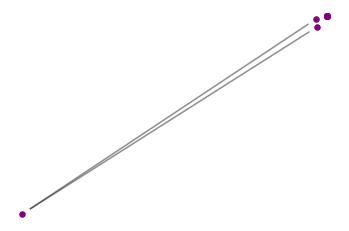

<Figure size 432x288 with 0 Axes>

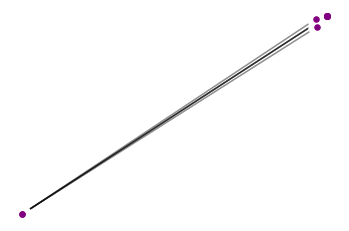

<Figure size 432x288 with 0 Axes>

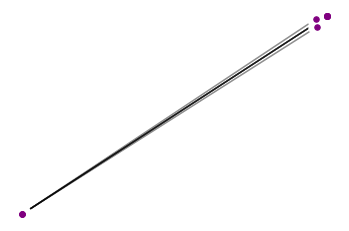

<Figure size 432x288 with 0 Axes>

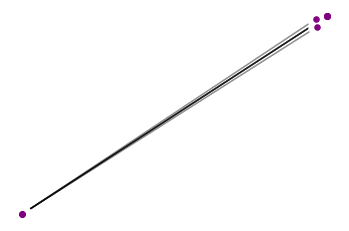

<Figure size 432x288 with 0 Axes>

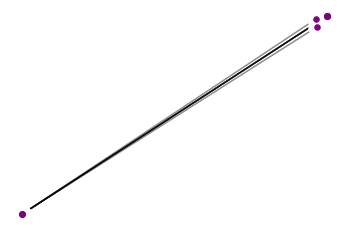

<Figure size 432x288 with 0 Axes>

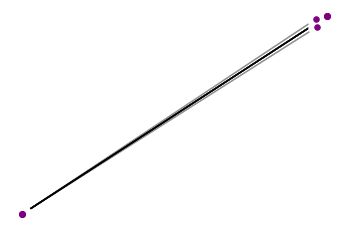

<Figure size 432x288 with 0 Axes>

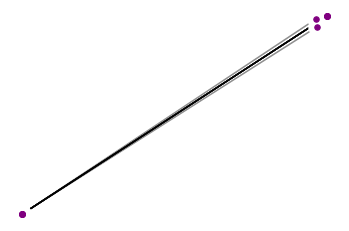

<Figure size 432x288 with 0 Axes>

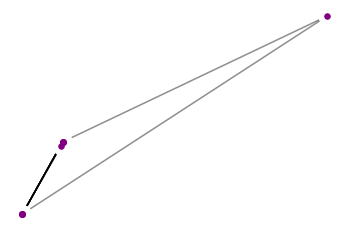

<Figure size 432x288 with 0 Axes>

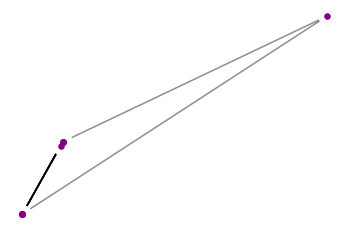

<Figure size 432x288 with 0 Axes>

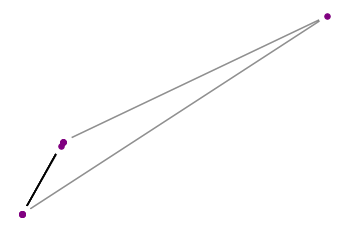

<Figure size 432x288 with 0 Axes>

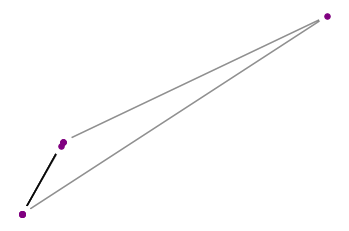

<Figure size 432x288 with 0 Axes>

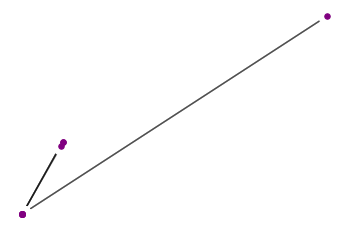

<Figure size 432x288 with 0 Axes>

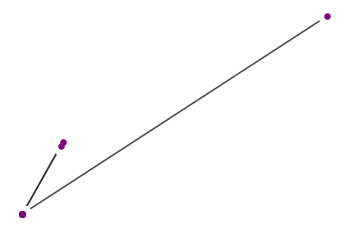

<Figure size 432x288 with 0 Axes>

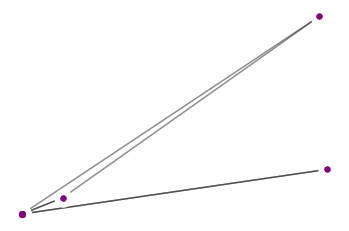

<Figure size 432x288 with 0 Axes>

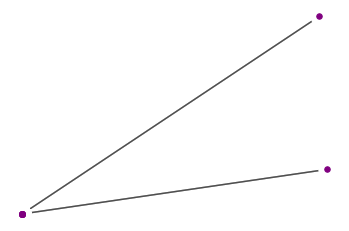

<Figure size 432x288 with 0 Axes>

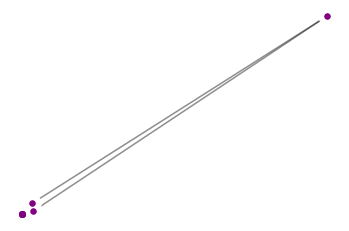

<Figure size 432x288 with 0 Axes>

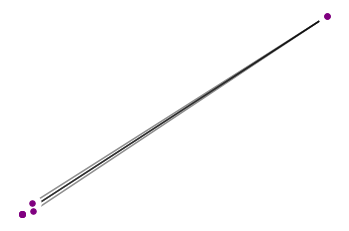

<Figure size 432x288 with 0 Axes>

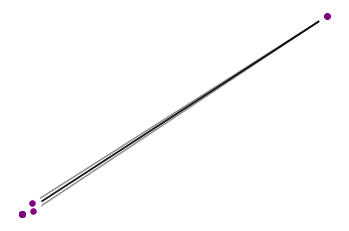

<Figure size 432x288 with 0 Axes>

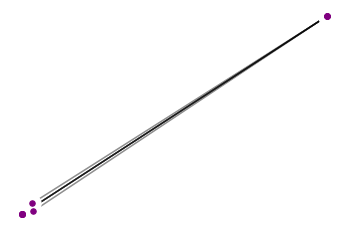

<Figure size 432x288 with 0 Axes>

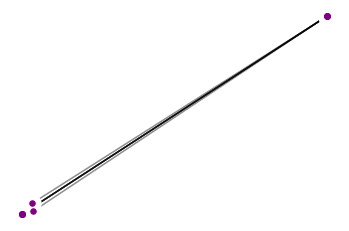

<Figure size 432x288 with 0 Axes>

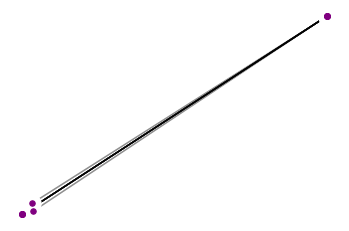

<Figure size 432x288 with 0 Axes>

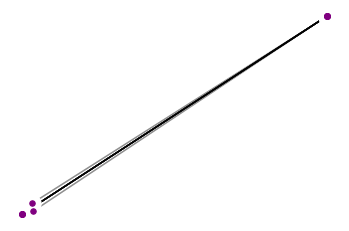

<Figure size 432x288 with 0 Axes>

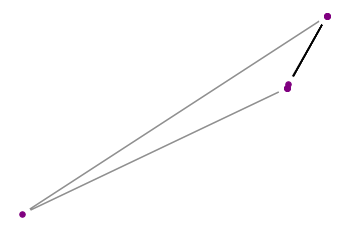

<Figure size 432x288 with 0 Axes>

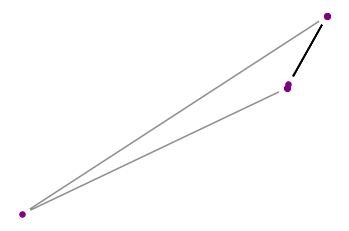

<Figure size 432x288 with 0 Axes>

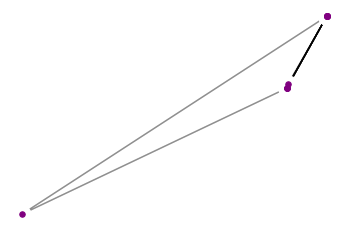

<Figure size 432x288 with 0 Axes>

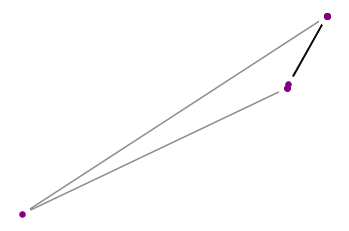

<Figure size 432x288 with 0 Axes>

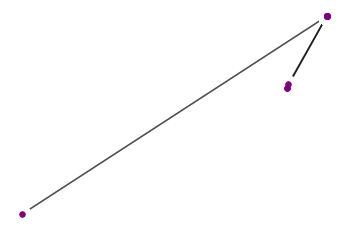

<Figure size 432x288 with 0 Axes>

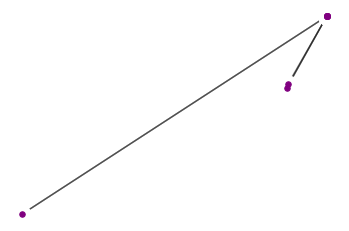

<Figure size 432x288 with 0 Axes>

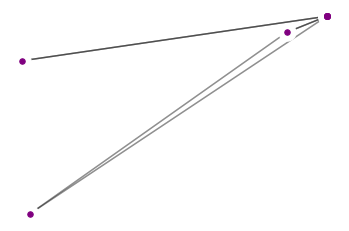

<Figure size 432x288 with 0 Axes>

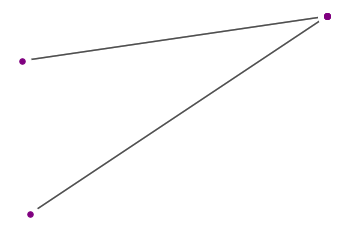

<Figure size 432x288 with 0 Axes>

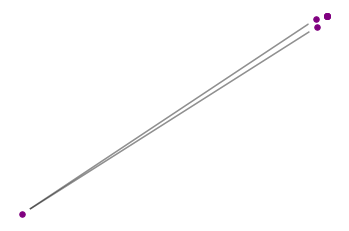

<Figure size 432x288 with 0 Axes>

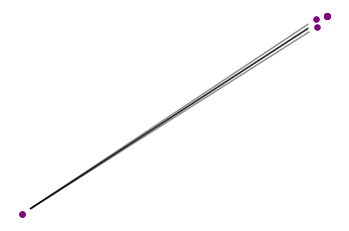

<Figure size 432x288 with 0 Axes>

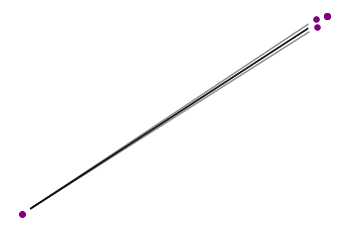

<Figure size 432x288 with 0 Axes>

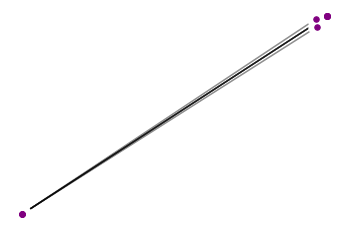

<Figure size 432x288 with 0 Axes>

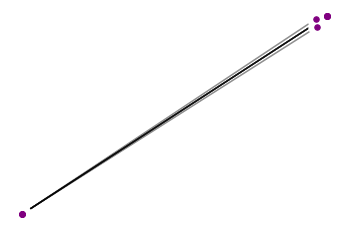

<Figure size 432x288 with 0 Axes>

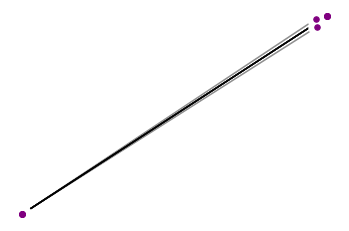

<Figure size 432x288 with 0 Axes>

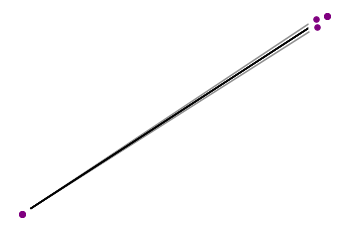

<Figure size 432x288 with 0 Axes>

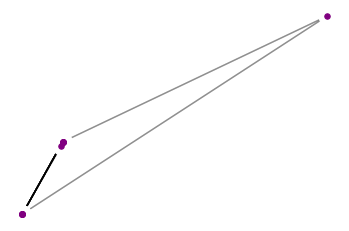

<Figure size 432x288 with 0 Axes>

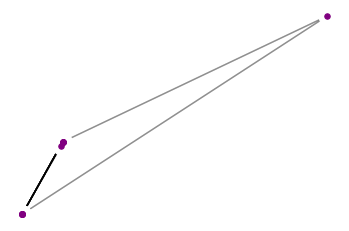

<Figure size 432x288 with 0 Axes>

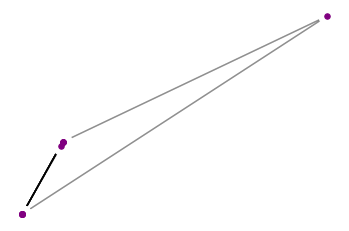

<Figure size 432x288 with 0 Axes>

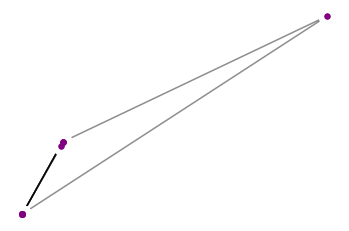

<Figure size 432x288 with 0 Axes>

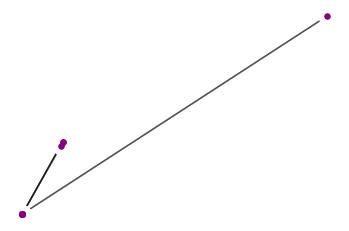

<Figure size 432x288 with 0 Axes>

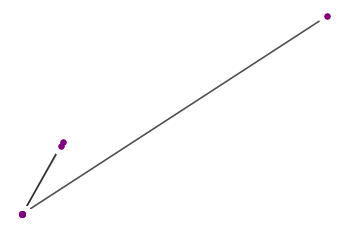

<Figure size 432x288 with 0 Axes>

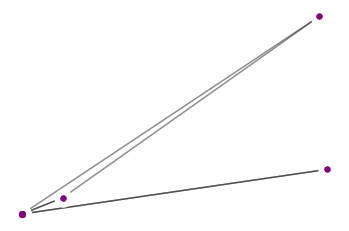

<Figure size 432x288 with 0 Axes>

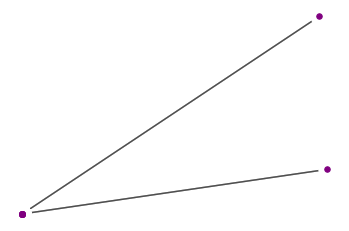

ZeroDivisionError: float division by zero

<Figure size 432x288 with 0 Axes>

In [53]:
from math import sqrt
#Spring rest length
spring_length = 500
repulsive_force_constant = 50.0
spring_force_constant = 25.0
dt = 0.6 #how much time passes each timestep
timesteps = 10
max_force = 100.0


def force_directed_layout(nodes,outfile="network.png", x_max=300.0,y_max=300.0):
    #Plot nodes as a scatterplot     
    x_coords = []
    y_coords = []
    
    for t in range(timesteps):
        for i,node in enumerate(nodes):    
            #Get x and y positions for each node.
            #On the first interaction, when they have no
            # x and y coordinates, set a random one
            x = node.Metadata['x']
            y = node.Metadata['y']
           
            
            #compare our node to each other node
            for j, node2 in enumerate(nodes):
                
                if i == j:
                    continue #don't compare nodes to themselves!
                
                
                x2 = node2.Metadata["x"]
                y2 = node2.Metadata["x"]
                
                dx,dy,dist_xy = get_node_distances(node,node2)

                if dist_xy == 0.0:
                    minimal_force = 0.001
                    x_force += minimal_force
                    y_force += minimal_force

                repulsive_force = repulsive_force_constant/dist_xy**2
                
                node.Metadata['x_force'] +=  repulsive_force * dx /dist_xy
                node.Metadata['y_force'] +=  repulsive_force * dy /dist_xy
                node2.Metadata['x_force'] -=  repulsive_force * dx /dist_xy
                node2.Metadata['y_force'] -=  repulsive_force * dy /dist_xy
                #Connected nodes also get pulled together by a 
                #spring force
                x_force,y_force = calc_2D_spring_force(node,other_node,spring_force_constant,spring_length)  
                node.Metadata['x_force'] += x_force
                node.Metadata['y_force'] += y_force    
                node2.Metadata['x_force'] -= x_force
                node2.Metadata['y_force'] -= y_force
              
        for i,node in enumerate(nodes):  
            node.Metadata["x"] = node.Metadata['x'] + node.Metadata['x_force'] * dt
            node.Metadata["y"] = node.Metadata['y'] + node.Metadata['y_force'] * dt
            
            er_network.plot()
            plt.show()
            plt.clf()
            
            
force_directed_layout(er_network.Nodes)

An image **with description field for screen readers**

<img src="./resources/linear_scatter_high_r2_linear_regression.png" width="400"  description="A cartoon of a scatter plot with x and y axes. A series of orange points is plotted. The points have some scatter to them, but roughly form a diagonal line from the lower left to the upper right of the plot. A black regression line runs diagonally through the points. ">

A simple math symbol: (see https://sites.psu.edu/symbolcodes/codehtml/#math and https://www.keynotesupport.com/internet/special-characters-greek-letters-symbols.shtml

y = &beta;<sub>0</sub>x<sub>0</sub>  + &beta;<sub>1</sub>x<sub>1</sub> + &beta;<sub>2</sub>x<sub>2</sub> + &beta;<sub>3
  
Split cells with cntrl-shift-minus

#### 4-color palette
- Bright green ( RGB 146,249,11)
- Orange (RGB 253,173,1)
- Magenta (RGB 255,19,170)
- Deep Blue (RGB 11,79,175)

## Exercises

## Reading Responses & Feedback 

^Make this a hyperlink using Google Forms

## Further Reading

## References